# 01 Importação dos pacotes e bibliotecas

In [ ]:
import numpy as np
import pandas as pd

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# 02 Importação do conjunto de dados

In [ ]:
# autenticação BQ
from google.colab import auth

auth.authenticate_user()

In [ ]:
# autenticação drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project='Insira o nome do seu projeto aqui')

df_comments = client.query('''SELECT * FROM `nme_projeto.youtube.df_comments`''').to_dataframe()

# 03 Modelo Estatístico

In [ ]:
def pooler(documents, iters, min_df=5, max_df=0.7, ngram=(1, 3), max_features=1000):
  '''
  Input:
      documents: coleção de documentos brutos que será convertido em uma  
                 matriz de recursos do TF-IDF.
      iters: número de iterações que será submetido o algoritmo MiniBatchKMeans
      min_df: frequência de documento mínima dos termos que serão considerados
      max_df: frequência de documento máxima dos termos que serão considerados
      ngram (ngram_range): o limite inferior e superior do intervalo de valores 
                           n para diferentes n-gramas a serem extraídos.
      max_features: considera apenas os max_features superiores ordenados 
                    por frequência de termo em todo o corpus.
  Output:
      models: modelo para cada numero de cluster (k)
      sse: inércia (inertia_) para cada numero
      vectorized: objeto de conversão dos documentos em uma matriz de recursos do TF-IDF
      vectorizer.get_feature_names_out(): nomes de recursos de saída para transformação
  '''

  # TfidfVectorizer converte uma coleção de documentos brutos em uma matriz de recursos do TF-IDF.
  # Equivalente a CountVectorizer, seguido por TfidfTransformer.
  vectorizer = TfidfVectorizer(
                              min_df=min_df, # Ignora os termos que têm uma frequência de documento estritamente INFerior ao limite fornecido
                              max_df=max_df, # Ignora os termos que têm uma frequência de documento estritamente SUPerior ao limite fornecido
                              ngram_range=ngram,
                              max_features=max_features
                              ).fit(documents)

  # aplica o objeto aos documentos 
  vectorized = vectorizer.transform(documents)

  # pooler model
  sse = []
  models = []
  for k in iters:
    
    # O MiniBatchKMeans é uma variante do algoritmo KMeans que usa minilotes para reduzir o tempo de cálculo, 
    # ao mesmo tempo que tenta otimizar a mesma função objetivo. 
    # Os minilotes são subconjuntos dos dados de entrada, amostrados aleatoriamente em cada iteração de treinamento. 
    # Esses minilotes reduzem drasticamente a quantidade de computação necessária para convergir para uma solução local. 
    # Em contraste com outros algoritmos que reduzem o tempo de convergência de k-means, 
    # o minilote k-means produz resultados que geralmente são apenas ligeiramente piores do que o algoritmo padrão.
    
    # modelo para cada numero de cluster (k)
    model = MiniBatchKMeans(n_clusters=k, init_size=256, batch_size=512, random_state=42).fit(vectorized)
    models.append(model)

    # A inertia_ mede o quão bem um conjunto de dados foi agrupado por K-Means. 
    # É calculado medindo a distância entre cada ponto de dados e seu centróide, 
    # elevando ao quadrado essa distância e somando esses quadrados em um cluster. 
    # Um bom modelo é aquele com baixa inércia E um baixo número de clusters (k).
    sse.append(model.inertia_)

    # Preve o cluster mais próximo ao qual cada amostra em X pertence.
    model.predict(vectorized)

  # USO SUSPENSO: get_feature_names() está obsoleto na versão 1.0 e será removido na versão 1.2.
  # Alternativamente, será usado get_feature_names_out() no seu lugar
  # get_feature_names_out() : Nomes de recursos de saída para transformação.
  return models, sse, vectorized, vectorizer.get_feature_names_out()

In [ ]:
from numpy import sqrt 

# o ponto que indica o equilíbrio entre a maior homogeneidade dentro do cluster 
# e a maior diferença entre os clusters é o ponto da curva que está 
# mais distante de uma linha traçada entre os pontos inicial e final
# fonte: https://jtemporal.com/kmeans-and-elbow-method/

# identificação do número ótimo de cluster para MiniBatchKMeans
def optimal_number_of_clusters(sse, iters):
  '''
  Input:
      sse: lista com valores de inércia (inertia_)
      iters: número de iterações que será submetido o algoritmo MiniBatchKMeans
  Output:
      distances.index(max(distances)) + iters[0]: número ideal de clusters
  '''
  x1, y1 = iters[0], sse[0]
  x2, y2 = iters[-1], sse[len(sse)-1]

  distances = []
  
  for i in range(len(sse)):
      x0 = i + iters[0]
      y0 = sse[i]
      numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
      denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
      distances.append(numerator/denominator)
  
  return distances.index(max(distances)) + iters[0]

In [ ]:

def get_model(models, k):
  '''
  Input:
      models: lista com modelos para cada numero de cluster (k)
      k: número ideal de clusters
  Output:
      models[c]: modelo com o número ideal de clusters
  '''
  c = (k - 2)

  return models[c]

In [ ]:
# identificação dos casos que pertencem a cada cluster.
def sort_best_binds(key, model):
  # calculate similarities
  similarities = []
  centroid = model.cluster_centers_[key]
  
  for v in vectorized:
    similarities.append(cosine_similarity([centroid], v))
  
  # best binds
  indexes = np.array([s[0][0] for s in similarities])
  indexes = np.argsort(indexes)[::-1]

  return indexes

In [ ]:
# lista de iterações
iters=range(2, 15, 1)

models, sse, vectorized, vocabulary = pooler(df_comments['textStemmed'].values.astype('U'), iters=iters)

# identifica o número ideal de cluster para a lista de inércia obtida
k = optimal_number_of_clusters(sse, iters)

# seleção do modelo com o número ideal de clusters
bestModel = get_model(models, k)

# preve o cluster mais próximo ao qual cada amostra em X pertence.
bestModel.predict(vectorized)

# classifica o comentario pelo cluster mais proximo
df_comments['cluster'] = bestModel.predict(vectorized)

topn = 20

from collections import Counter

print(df_comments.groupby('cluster')['textStemmed'].apply(lambda x: Counter(" ".join(x).split()).most_common(5)))

for i in range(len(bestModel.cluster_centers_)):
  indexes = sort_best_binds(i,bestModel)
  values1 = df_comments.iloc[indexes[:topn]].textStemmed.values
  values2 = df_comments.iloc[indexes[:topn]].textDisplay.values
  print(f'\nCluster: {i}')
  for v in range(topn):
    print(values1[v][:200],' | ',values2[v][:200])

cluster
0     [(mud, 27), (vid, 24), (jog, 11), (carr, 9), (...
1     [(entrar, 122), (pra, 54), (vou, 41), (jog, 30...
2     [(carr, 117), (pra, 107), (vai, 94), (cryptoCC...
3     [(quer, 60), (entrar, 34), (val, 25), (pen, 20...
4     [(sub, 56), (vai, 19), (cryptoCCAR, 14), (moed...
5     [(jog, 185), (pra, 28), (carr, 26), (melhor, 2...
6     [(dia, 155), (carr, 82), (cryptoCCAR, 72), (me...
7     [(car, 76), (bom, 47), (jog, 18), (projet, 16)...
8     [(obrig, 41), (ajud, 6), (jog, 5), (invest, 4)...
9     [(comec, 62), (pra, 23), (jog, 18), (invest, 1...
10    [(nft, 76), (jog, 41), (melhor, 14), (projet, ...
11    [(cryptoCCAR, 70), (lua, 48), (carr, 13), (cpa...
12    [(tod, 52), (qued, 23), (tud, 22), (jog, 19), ...
Name: textStemmed, dtype: object

Cluster: 0
mud vid  |  mudou minha vida!
cryptoCCAR mud vid  |  ccar mudando vidas!
real mud vid  |  realmente mudando vidas 
jog mud vid dig rsr  |  esse jogo mudou minha vida, so digo isso rsrs
excel gam mud vid  |  excelente ga

In [ ]:

# no dicionario abaixo são incluidos manualmente os motivos de cada cluster
# se não for possivel classificá-lo, usar a definiçao 'desconhecido'
maps = {
0: 'mudança de vida',
1: 'sobre o momento de entrada no jogo',
2: 'desconhecido',
3: 'querem entrar no jogo',
4: 'otimismo com subida/valorização da moeda',
5: 'sobre o jogo em si',
6: 'sobre perfomance no jogo',
7: 'desconhecido',
8: 'desconhecido',
9: 'desconhecido',
10: 'sobre mercado de NFT',
11: 'jogo é lua',
12: 'desconhecido'}

def prepare_train_data(df):
  '''
  Input:
      df: conjunto de dados que receberá definições
  Output:
      df: conjunto de dados com as definições aplicadas (remoção dos 'desconhecido')
  '''

  df = df.replace({'cluster': maps})
  df = df[df['cluster'] != 'desconhecido']

  return df

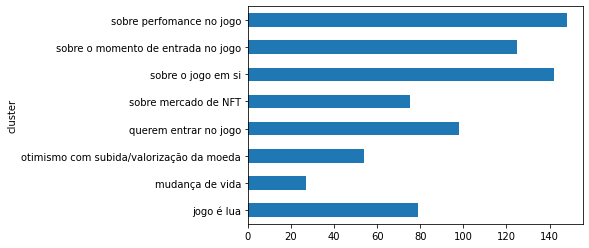

In [ ]:

# cria um conjunto de dados classificado
train_data = prepare_train_data(df_comments)

train_data.groupby('cluster')['cluster'].count().plot.barh()

# 04 Exportação do conjunto de dados para o GCP

In [ ]:
import pandas_gbq

from google.oauth2 import service_account

def save_gbq(df, channel_name, nome_tabela, path_json_key):
  '''
  Input:
      df: conjunto de dados a ser carregado no GCP
      channel_name: nome do canal
      nome_tabela: nome que será dado ao conjunto de dados carregado
      path_json_key: chave json para a autenticaçao do acesso
  '''
  credentials = service_account.Credentials.from_service_account_file(path_json_key)
  pandas_gbq.to_gbq(dataframe = df,
                    destination_table = f'{channel_name}.{nome_tabela}',
                    project_id = 'Insira o nome do seu projeto aqui',
                    credentials = credentials,
                    if_exists='replace')

save_gbq(train_data, 'youtube', 'train_data', 'Insira o caminho de seu arquivo json aqui')

1it [00:06,  6.50s/it]
